# Анализ кадастровой стоимости земели в Томском регионе для целей ЛПХ и сельского хозяйства

# 1 Анализ кадастровой стоимости земли для целей сельского хозяйства

##1.1 Подключим необходимые библиотеки и объявим основные переменные

В качестве основных переменных выступают:
* `df` - таблица с данными;
* `path_dataset`- путь до датасета в google drive.

In [ ]:
# Работа с данными
from pathlib import Path
import json
import pandas as pd
from google.colab import drive

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns
import math
from collections import Counter

# Подсчет дистанции
from geopy.geocoders import Nominatim
from geopy.distance import geodesic

drive.mount('/content/drive')
agro_purpose_df = pd.DataFrame(columns=["площадь", "упкс", "локация"])
path_dataset = '/content/drive/MyDrive/cad_dataset/'
path_list = Path(path_dataset).glob('*.json')
None

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.2 Выгрузим необходимую информацию
Нас интересуют в первую очередь такие столбцы:
* `площадь` - площадь земли, измеряемая в квадратных метрах;
* `УПКС`- удельный показатель кадастровой стоимости;
* `адрес` - регион, город, район и улица земельного участка.

In [ ]:
agro_purpose_df = pd.DataFrame(columns=["площадь", "упкс", "локация"])
for path in path_list:
  with open(path, encoding="utf-8") as f:
    data = f.read()
  data =  json.loads(data)
  for row in data:
    if ('text' in row['purpose'] and
        row['purpose']['text'] == "Для сельскохозяйственного использования" and
        'locality' in row['address']):
      agro_purpose_df.loc[len(agro_purpose_df.index )] = [row['area'], row['cadCost']['upks'], row['address']['locality']]
agro_purpose_df.to_csv(path_dataset + "itog.csv")

## 1.3 Создание нового признака `расстояние` населенного пункта до ближайшего города

Загрузим данные

In [ ]:
agro_purpose_df = pd.read_csv(path_dataset + "itog.csv")

Отсортируем цену по возрастанию и отсечем выбросы. Можно заметить, что цена варируется от 0.2 до 2.5 рублей за квадратный метр.

<BarContainer object of 1690 artists>

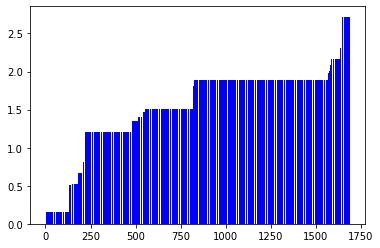

In [ ]:
tmp2 = sorted(agro_purpose_df['упкс'])[:1690]
plt.bar(range(len(tmp2)), tmp2, color = 'blue')

Создаем короткий и полный список деревень

In [ ]:
villages = []
for row in agro_purpose_df['локация']:
  villages.append(row)
short_villages = list(Counter(villages).keys())

Находим географические координаты основных городов Томской области

In [ ]:
citys = dict()

cities = ["Томск", "Асино", "Колпашево", "Стрежевой"]
country = "Россия, Томская область,"

for city in cities:
  geolocator = Nominatim(user_agent="Tester")
  location_1 = geolocator.geocode(country + city)
  citys[city] = (location_1.latitude, location_1.longitude)

citys

{'Томск': (56.4884594, 84.9527189),
 'Асино': (56.999187, 86.14167),
 'Колпашево': (58.313667, 82.903557),
 'Стрежевой': (60.732758, 77.600807)}

In [ ]:
def dist_near_city(address_1):
  min_dist = 10000000;
  for city in citys:
    geolocator = Nominatim(user_agent="Tester", timeout=None)
    location_1 = geolocator.geocode(country + address_1)
    if not location_1:
      min_dist = 50.0
      break
    gps_point_1 = location_1.latitude, location_1.longitude
    if geodesic(gps_point_1, citys[city]).kilometers < min_dist:
      min_dist = geodesic(gps_point_1, citys[city]).kilometers

  return min_dist

Формируем словарь расстояний деревень до ближайших городов

In [ ]:
dists = dict()

counter = 0
for village in short_villages:
  dists[village] = dist_near_city(village)


Добавляем столбец `расстояние` в исходную таблицу и сохраняем

In [ ]:
d = []
counter = 0
for village in villages:
  d.append(dists[village])
agro_purpose_df['расстояние'] = d
agro_purpose_df.to_csv(path_dataset + "agro.csv")

In [ ]:
agro_purpose_df = pd.read_csv(path_dataset + "agro.csv")

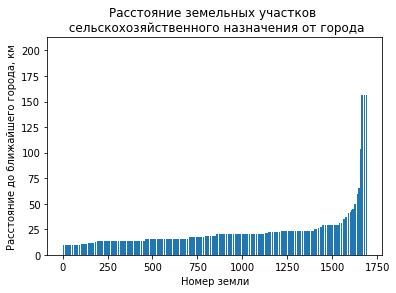

In [ ]:
tmp = sorted(agro_purpose_df['расстояние'])
fig, ax = plt.subplots()
ax.bar(range(len(tmp)), tmp)
ax.set_title(u'Расстояние земельных участков \n сельскохозяйственного назначения от города')
ax.set_xlabel('Номер земли')
ax.set_ylabel('Расстояние до ближайшего города, км')
plt.show()

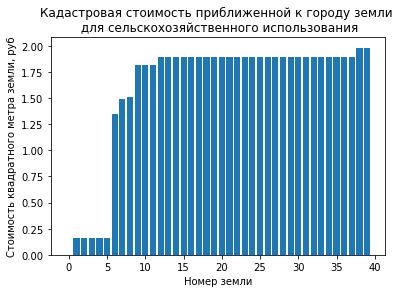

In [ ]:
tmp3 = sorted(agro_purpose_df.loc[agro_purpose_df['расстояние'] > 75]['упкс'])
fig, ax = plt.subplots()
ax.bar(range(len(tmp3)), tmp3)
ax.set_title(u'Кадастровая стоимость удаленной от города земли \n для сельскохозяйственного использования')
ax.set_xlabel('Номер земли')
ax.set_ylabel('Стоимость квадратного метра земли, руб')
plt.show()

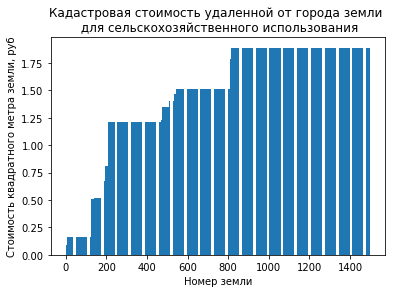

In [ ]:
fig, ax = plt.subplots()
tmp4 = sorted(agro_purpose_df.loc[agro_purpose_df['расстояние'] < 75]['упкс'])[:1500]
plt.bar(range(len(tmp4)), tmp4)
ax.set_title(u'Кадастровая стоимость приближенной к городу земли \n для сельскохозяйственного использования')
ax.set_xlabel('Номер земли')
ax.set_ylabel('Стоимость квадратного метра земли, руб')
plt.show()

# 2 Анализ кадастровой стоимости земли для целей ЛПХ

##2.1 Подготавливаем данные

In [ ]:
lph_purpose_df = pd.DataFrame(columns=["площадь", "упкс", "локация", "расстояние"])
lph_purpose_df = pd.read_csv(path_dataset + "lph.csv")

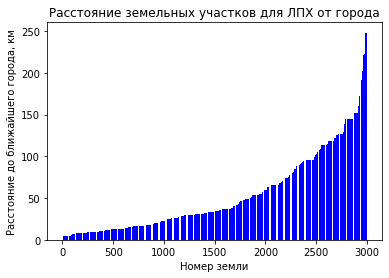

In [ ]:
fig, ax = plt.subplots()

tmp10 = sorted(lph_purpose_df['расстояние'])
plt.bar(range(len(tmp10)), tmp10, color = 'blue')
ax.set_title(u'Расстояние земельных участков для ЛПХ от города')
ax.set_xlabel('Номер земли')
ax.set_ylabel('Расстояние до ближайшего города, км')
plt.show()

In [ ]:
for path in path_list:
  with open(path, encoding="utf-8") as f:
    data = f.read()
  data =  json.loads(data)
  for row in data:
    if ('text' in row['purpose'] and
        row['purpose']['text'] == "Для ведения личного подсобного хозяйства" and
        'locality' in row['address']):
      lph_purpose_df.loc[len(lph_purpose_df.index )] = [row['area'], row['cadCost']['upks'], row['address']['locality']]
lph_purpose_df.to_csv(path_dataset + "itog2.csv")

Empty DataFrame
Columns: [площадь, упкс, локация]
Index: []
<generator object Path.glob at 0x7f52a6272120>


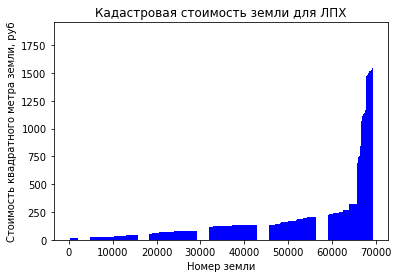

In [ ]:
fig, ax = plt.subplots()

tmp10 = sorted(lph_purpose_df['упкс'])
plt.bar(range(len(tmp10)), tmp10, color = 'blue')
ax.set_title(u'Кадастровая стоимость земли для ЛПХ')
ax.set_xlabel('Номер земли')
ax.set_ylabel('Стоимость квадратного метра земли, руб')
plt.show()

In [ ]:
new_lph_df = lph_purpose_df.sample(3000)

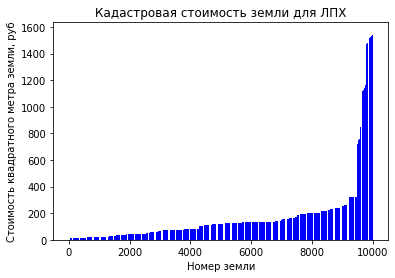

In [ ]:
fig, ax = plt.subplots()

tmp10 = sorted(new_lph_df['упкс'])
plt.bar(range(len(tmp10)), tmp10, color = 'blue')
ax.set_title(u'Кадастровая стоимость земли для ЛПХ')
ax.set_xlabel('Номер земли')
ax.set_ylabel('Стоимость квадратного метра земли, руб')
plt.show()

In [ ]:
lph_villages = []
for row in new_lph_df['локация']:
  lph_villages.append(row)
short_lph_villages = list(Counter(lph_villages).keys())
len(short_lph_villages)

352

In [ ]:
dists_lph = dict()

counter = 0
for lph_village in short_lph_villages:
  counter += 1
  print(counter)
  dists[lph_village] = dist_near_city(lph_village)

In [ ]:
d_lph = []
counter = 0
for village in lph_villages:
  d_lph.append(dists[village])
new_lph_df['расстояние'] = d_lph
new_lph_df.to_csv(path_dataset + "lph.csv")

In [ ]:
new_lph_df

,площадь,упкс,локация,расстояние
370,1490.0,129.65,Зырянское,34.503670
23154,500.0,133.51,Малиновка,33.545685
59828,1500.0,319.91,Зональная Станция,8.077830
35364,1100.0,1176.62,Апрель,13.352126
22108,2280.0,166.24,Каргасок,144.230673
...,...,...,...,...
11217,1400.0,138.73,Моряковский Затон,29.517926
50032,1800.0,33.44,Высокий Яр,104.901817
4549,2000.0,40.22,Плотниково,121.915599
18954,1698.0,58.77,Батурино,25.758570


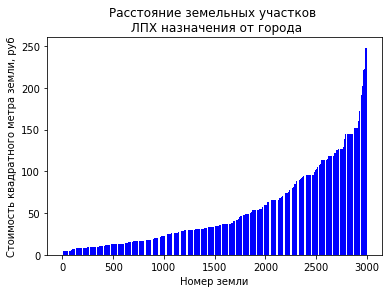

In [ ]:
fig, ax = plt.subplots()

tmp11 = sorted(new_lph_df['расстояние'])
plt.bar(range(len(tmp11)), tmp11, color = 'blue')
ax.set_title(u'Расстояние земельных участков \n ЛПХ назначения от города')
ax.set_xlabel('Номер земли')
ax.set_ylabel('Стоимость квадратного метра земли, руб')
plt.show()

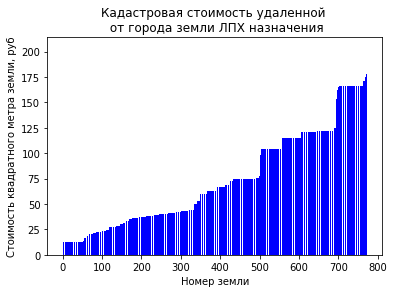

In [ ]:
tmp13 = sorted(new_lph_df.loc[new_lph_df['расстояние'] > 75]['упкс'])
fig, ax = plt.subplots()
ax.bar(range(len(tmp13)), tmp13, color='b')
ax.set_title(u'Кадастровая стоимость удаленной \n от города земли ЛПХ назначения')
ax.set_xlabel('Номер земли')
ax.set_ylabel('Стоимость квадратного метра земли, руб')
plt.show()

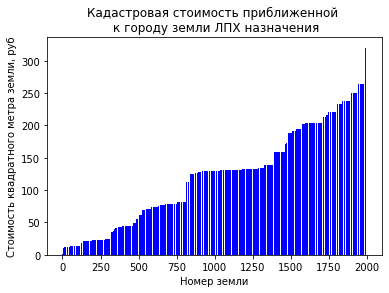

In [ ]:
tmp14 = sorted(new_lph_df.loc[new_lph_df['расстояние'] < 75]['упкс'])[:2000]
fig, ax = plt.subplots()
ax.bar(range(len(tmp14)), tmp14, color='b')
ax.set_title(u'Кадастровая стоимость приближенной \n к городу земли ЛПХ назначения')
ax.set_xlabel('Номер земли')
ax.set_ylabel('Стоимость квадратного метра земли, руб')
plt.show()